<a href="https://colab.research.google.com/github/sangeetajay/Springboard/blob/master/4_AH_preprocessing_modeling_home_features.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Final Capstone Project:
# Predicting Austin Home Prices from Zillow Images

## Pre-Processing/Modeling Notebook 4:
In this notebook, we will use some of the features that accompanied the home images and pre-process these for modeling using a deep neural network, in preparation for combining these with the images in a CNN. 

Sections:
1. Imports
2. Prepare Home Features Data
3. Modeling: Linear Regression
4. Modeling: Neural Network




## 1. Imports

In [66]:
import numpy as np
import os
import pandas as pd 
import matplotlib.pyplot as plt


from sklearn.utils import shuffle
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.linear_model import LinearRegression

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import applications
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization, GlobalAveragePooling2D, Flatten, Conv2D, MaxPooling2D
from tensorflow.keras.utils import Sequence
from tensorflow.keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D
# import the necessary packages
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Activation
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model

from keras import backend as K



## 2. Prepare Home Features Data:

#### 2.a. Load dataset and final cleaning

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
# load the cleaned dataset with the features

file = '/content/drive/MyDrive/cleaned_features_data_v1.csv'
features = pd.read_csv(file)

features.head()



,Price,Image Name,zipcode,longitude,livingAreaSqFt,numOfBathrooms,numOfBedrooms,numOfPrimarySchools,numOfHighSchools,avgSchoolRating
0,305000,111373431_ffce26843283d3365c11d81b8e6bdc6f-p_f,78660,-97.663078,2601.0,3.0,4,1,1,2.666667
1,295000,120900430_8255c127be8dcf0a1a18b7563d987088-p_f,78660,-97.661697,1768.0,2.0,4,1,1,2.666667
2,256125,2084491383_a2ad649e1a7a098111dcea084a11c855-p_f,78660,-97.639771,1478.0,2.0,3,0,1,3.000000
3,240000,120901374_b469367a619da85b1f5ceb69b675d88e-p_f,78660,-97.661659,1678.0,2.0,3,1,1,2.666667
4,239900,60134862_b1a48a3df3f111e005bb913873e98ce2-p_f,78660,-97.656860,2132.0,3.0,3,1,1,4.000000


In [4]:
# lets drop image name for now
features = features.drop(columns=['Image Name'])

In [5]:
# get names of the columns
features.columns

Index(['Price', 'zipcode', 'longitude', 'livingAreaSqFt', 'numOfBathrooms',
       'numOfBedrooms', 'numOfPrimarySchools', 'numOfHighSchools',
       'avgSchoolRating'],
      dtype='object')

In [6]:
features.info() # inspect the data

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15012 entries, 0 to 15011
Data columns (total 9 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Price                15012 non-null  int64  
 1   zipcode              15012 non-null  int64  
 2   longitude            15012 non-null  float64
 3   livingAreaSqFt       15012 non-null  float64
 4   numOfBathrooms       15012 non-null  float64
 5   numOfBedrooms        15012 non-null  int64  
 6   numOfPrimarySchools  15012 non-null  int64  
 7   numOfHighSchools     15012 non-null  int64  
 8   avgSchoolRating      15012 non-null  float64
dtypes: float64(4), int64(5)
memory usage: 1.0 MB


In [7]:
# convert zipcode column to a string so we can make dummy variables
features['zipcode'] = features['zipcode'].astype(str)

#### 2b.Create Dummy Variables for Categorical Features (Zipcode)

In [8]:

# features except Target feature
feature_cols = ['zipcode', 'longitude', 'livingAreaSqFt', 'numOfBathrooms',
       'numOfBedrooms', 'numOfPrimarySchools', 'numOfHighSchools',
       'avgSchoolRating']
new_X = features[feature_cols]
new_X.columns


Index(['zipcode', 'longitude', 'livingAreaSqFt', 'numOfBathrooms',
       'numOfBedrooms', 'numOfPrimarySchools', 'numOfHighSchools',
       'avgSchoolRating'],
      dtype='object')

In [9]:
# create dataframe with features and dummy variables called features_df
features_df = pd.get_dummies(new_X)
features_df.head()

,longitude,livingAreaSqFt,numOfBathrooms,numOfBedrooms,numOfPrimarySchools,numOfHighSchools,avgSchoolRating,zipcode_78617,zipcode_78619,zipcode_78652,zipcode_78653,zipcode_78660,zipcode_78701,zipcode_78702,zipcode_78703,zipcode_78704,zipcode_78705,zipcode_78717,zipcode_78719,zipcode_78721,zipcode_78722,zipcode_78723,zipcode_78724,zipcode_78725,zipcode_78726,zipcode_78727,zipcode_78728,zipcode_78729,zipcode_78730,zipcode_78731,zipcode_78732,zipcode_78733,zipcode_78734,zipcode_78735,zipcode_78736,zipcode_78737,zipcode_78738,zipcode_78739,zipcode_78741,zipcode_78742,zipcode_78744,zipcode_78745,zipcode_78746,zipcode_78747,zipcode_78748,zipcode_78749,zipcode_78750,zipcode_78751,zipcode_78752,zipcode_78753,zipcode_78754,zipcode_78756,zipcode_78757,zipcode_78758,zipcode_78759
0,-97.663078,2601.0,3.0,4,1,1,2.666667,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,-97.661697,1768.0,2.0,4,1,1,2.666667,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,-97.639771,1478.0,2.0,3,0,1,3.000000,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,-97.661659,1678.0,2.0,3,1,1,2.666667,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,-97.656860,2132.0,3.0,3,1,1,4.000000,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


#### 2c. Split into Train and Test sets

In [10]:
# refreshing what the columns are in the df
features.columns

Index(['Price', 'zipcode', 'longitude', 'livingAreaSqFt', 'numOfBathrooms',
       'numOfBedrooms', 'numOfPrimarySchools', 'numOfHighSchools',
       'avgSchoolRating'],
      dtype='object')

In [11]:

# define your X and y
X = features_df
y = features['Price']

# split into test and train
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=200)

#### 2d. Scale the Data

In [12]:
# build scaler based on training data and apply it to test data to then also scale the test data
scaler = preprocessing.StandardScaler().fit(X_train)
X_train_scaled=scaler.transform(X_train)
X_test_scaled=scaler.transform(X_test)

## 3. Modeling: Linear Regression


In [17]:
# Train the model on the train split

lr = LinearRegression().fit(X_train_scaled, y_train)

In [18]:
# Make predictions using the model on both train and test splits

y_train_pred = lr.predict(X_train_scaled)
y_test_pred = lr.predict(X_test_scaled)

In [20]:
# Assess model performance
from sklearn.metrics import r2_score
r2_score(y_train, y_train_pred), r2_score(y_test, y_test_pred)

(0.5769922147920092, 0.631031370606283)

In [22]:
from sklearn.metrics import mean_absolute_error
mean_absolute_error(y_train, y_train_pred), mean_absolute_error(y_test, y_test_pred)
# this means we could be off by 130-140K !!!

(137777.11457427708, 141318.34992400068)

In [24]:
from sklearn.metrics import mean_squared_error
mean_squared_error(y_train, y_train_pred), mean_squared_error(y_test, y_test_pred)

(79220366151.41327, 84030614657.44089)

##### Conclusion: 
The linear regression model does not perform that well, with r2 score of 0.57 and 0.63
(but is much better than our CNN from the images in notebook 3).


## 4. Modeling: Neural Network

#### 4a. Metrics function

In [25]:
# Write a function to calculate coefficient of determination
def coeff_determination(y_true, y_pred):
    SS_res =  K.sum(K.square( y_true-y_pred )) 
    SS_tot = K.sum(K.square( y_true - K.mean(y_true) ) ) 
    return ( 1 - SS_res/(SS_tot + K.epsilon()) )

#### 4b. Create and compile model

In [26]:

model = Sequential()
model.add(Dense(16, activation="relu"))
model.add(Dense(8, activation="relu"))
model.add(Dense(1, activation="linear"))
model.compile(optimizer='adam', loss="mean_absolute_error", 
              metrics=[[coeff_determination, 'mean_absolute_error']])
 

#### 4c. Train the model

In [27]:
history = model.fit(x=X_train_scaled, y=y_train,
                  validation_data=(X_test_scaled, y_test), epochs=100, batch_size=32)
            

Epoch 1/100
376/376 [==============================] - 2s 2ms/step - loss: 510809.9688 - coeff_determination: -3.0291 - mean_absolute_error: 510809.9688 - val_loss: 519807.4375 - val_coeff_determination: -2.6794 - val_mean_absolute_error: 519807.4375
Epoch 2/100
376/376 [==============================] - 1s 2ms/step - loss: 510760.2812 - coeff_determination: -3.0462 - mean_absolute_error: 510760.2812 - val_loss: 519691.8438 - val_coeff_determination: -2.6782 - val_mean_absolute_error: 519691.8438
Epoch 3/100
376/376 [==============================] - 1s 2ms/step - loss: 510528.6250 - coeff_determination: -3.0694 - mean_absolute_error: 510528.6250 - val_loss: 519327.8125 - val_coeff_determination: -2.6742 - val_mean_absolute_error: 519327.8125
Epoch 4/100
376/376 [==============================] - 1s 2ms/step - loss: 510012.7188 - coeff_determination: -3.0363 - mean_absolute_error: 510012.7188 - val_loss: 518650.1250 - val_coeff_determination: -2.6668 - val_mean_absolute_error: 518650.1

#### 4d. Visualize model performance

In [94]:

SMALL_SIZE = 16
MEDIUM_SIZE = 20
BIGGER_SIZE = 28

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

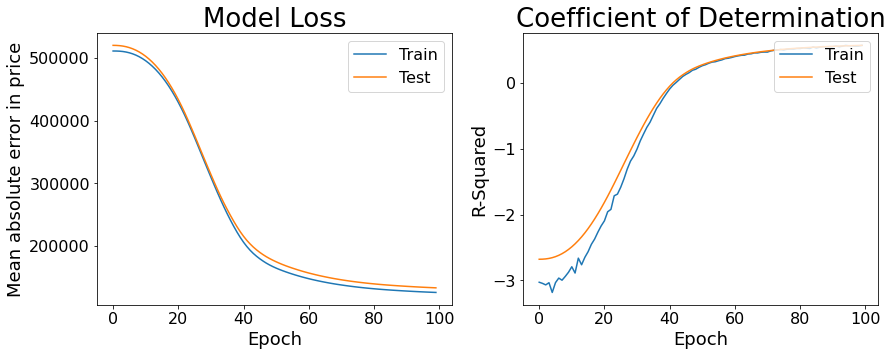

In [98]:
# create figure
fig= plt.figure(figsize=(14,5))
#plt.suptitle('Artifical Neural Network on Home Features')
titlesize=26
fontsize=18
# loss plot on left
plt.subplot(1,2, 1)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
         
plt.title('Model Loss', fontsize=titlesize)
plt.ylabel('Mean absolute error in price', fontsize=fontsize)
plt.xlabel('Epoch', fontsize=fontsize)
plt.legend(['Train', 'Test'], loc='upper right')

# coeff plot on right
plt.subplot(1,2, 2)
plt.plot(history.history['coeff_determination'])
plt.plot(history.history['val_coeff_determination'])

plt.title('Coefficient of Determination', fontsize= titlesize)
plt.ylabel('R-Squared',  fontsize=fontsize)
plt.xlabel('Epoch', fontsize=fontsize)
plt.legend(['Train', 'Test'], loc='upper right')

plt.show()